### Метод BFGS

#### Условие Вольфе
Сперва реализуем линейный поиск с условиями Вольфе. Это нам понадобится при  реализации BFGS (он опирается на одномерный поиск, для которого соблюдение условий Вольфа обязательно).

In [1]:
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
def wolfe_search(f, x, p, grad, nabla, max_it = 20):
    '''
    Поиск с условиями Вольфе
    '''
    a = 1
    c1 = 1e-4 
    c2 = 0.9 
    fx = f(*x)

    x_new = x + a * p 
    nabla_new = np.array(grad(*x_new))
    for _ in range(0, max_it):
        if not (f(*x_new) >= fx + (c1*a*np.array(nabla).T @ p) or nabla_new.T @ p <= c2*(np.array(nabla)).T @ p):
            break 
        a *= 0.5
        x_new = x + a * p 
        nabla_new = np.array(grad(*x_new))
    return a

#### Реализация метода

Что нужно иметь в виду: 
1. в алгоритме не используется и не вычисляется Гессиан как таковой, нам нужно только
хорошее приближение.
2. по этой причине асимптотика у каждого шага O(n^2), а не O(n^3), это важное преимущество над обычным метоодом Ньютона
3. BFGS более общий, чем метод Гаусса-Ньютона.

$$ H_{k+1}^{-1} = \left(I - \frac{s_k y_k^T}{y_k^T s_k}\right) H_k^{-1} \left(I - \frac{y_k s_k^T}{y_k^T s_k}\right) + \frac{s_k s_k^T}{y_k^T s_k} $$

In [3]:
def BFGS(f_batch, batch_size, x0, grad, epochs = 100):
    '''
    Реализация BFGS
    Параметры
    f:      целевая функция 
    x0:     начальная гипотеза
    epochs: максимальное число итераций 
    вывод: 
    x:      найденный минимум 
    '''
    f = f_batch(batch_size)
    
    d = len(x0) # наша размерность 
    # print(f'{x0=}')
    nabla = np.array(grad(*x0)) # градиент в начальной точке
    I = np.eye(d) # единичная матрица

    H = np.copy(I) # начальный обратный гессиан
    x = np.copy(x0)

    points = []
    for i in range(1, epochs):
        if np.linalg.norm(nabla) < 1e-5:
            break 
        print(i)

        p = -H @ nabla # направление поиска
        a = wolfe_search(f, x, p, grad, nabla) # поиск с условиями Вольфе 
        s = np.array([a * p]) # величина шага (dx)
        x_new = x + a * p 
        nabla_new = np.array(grad(*x_new))
        y = np.array([nabla_new - nabla]) # d(nabla f)

        y, s = np.reshape(y,(d,1)), np.reshape(s,(d,1))
        y_trans, s_trans = y.transpose(), s.transpose()
        
        r = 1/(y_trans @ s + 1e-20)

        # это можно вычислить более эффективно без временных матриц        
        li = I-(r*(s @ (y_trans)))
        ri = I-(r*(y @ (s_trans)))
        h_inter = li @ H @ ri
        H = h_inter + (r*(s @ s_trans)) # обновление (обратного) гессиана
        
        nabla = np.copy(nabla_new)
        x = np.copy(x_new)
        
        points.append(x)
    return points

In [4]:
def grad_batch(f_batch_size, batch_size):
    def grad_help(*args):
        h = 1e-10
        dim = len(args)
        
        f = f_batch_size(batch_size)
        return [(
                        f(*[args[j] + (h if j == i else 0) for j in range(dim)])
                        -
                        f(*[args[j] - (h if j == i else 0) for j in range(dim)])
                ) / (2 * h)
                for i in range(dim)]
    return grad_help


In [5]:
def regression(x, y, method, batch_size=3, **config):
    if config == {}:
        config = {"lr0": 0.5, "d": 0.005, "epoch": 1000}
    x_mat = np.hstack((np.ones((x.shape[0], 1)), x))
    n = x_mat.shape[1] # the dimenstion 
    

    batch_choice = lambda batch_size: list(set(np.random.choice(np.arange(x.shape[0]), batch_size, replace=False)))    
    f_batch = lambda batch_size: \
                       lambda *b, batch=batch_choice(batch_size): \
                           np.linalg.norm(y[batch] - x_mat[batch].dot(b))
    
    bs = np.array(method(f_batch, batch_size, np.full(n, 1), grad_batch(f_batch, batch_size)))
    
    f = f_batch(x.shape[0]) # the entire function 
    print(f'came close by {f(*bs[-1])}')
    ax = plt.figure().add_subplot()
    X = np.arange(len(bs))
    ax.plot(X, np.vectorize(f)(*bs.T))
    ax.grid()
    return bs

In [6]:
rand = lambda n: (np.random.rand(n)*2)-1

def random_perfect_line(n, k, k_limit, ms_limit, debug=False):
    m = rand(n) * ms_limit
    s = rand(n) * ms_limit
    ks = rand(k) * k_limit
    xy = np.array([m + s * k for k in ks])
    x = xy[:, :-1]
    y = xy[:, -1]
    return x, y

In [7]:
line = random_perfect_line(25, 100, 100, 100)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
came close by 1078.615313145122


array([[ 9.99900357e-01,  1.02628814e+00,  8.58957822e-01, ...,
         8.84423840e-01,  1.06252776e+00,  1.11790346e+00],
       [ 9.83581100e-01,  1.90459070e+00,  7.81669531e-01, ...,
        -4.79080614e-01,  2.68797254e+00, -2.91717060e-01],
       [ 9.99459939e-01,  1.14110474e+00,  8.70066217e-01, ...,
         7.18605482e-01,  1.27175413e+00,  9.06432094e-01],
       ...,
       [-7.16207118e+02,  5.69615007e+02, -8.56645067e+02, ...,
         9.07264998e+02,  6.91222411e+01, -4.09511648e+02],
       [-7.16207116e+02,  5.69615008e+02, -8.56645064e+02, ...,
         9.07265000e+02,  6.91222404e+01, -4.09511645e+02],
       [-7.16207116e+02,  5.69615008e+02, -8.56645064e+02, ...,
         9.07265000e+02,  6.91222404e+01, -4.09511645e+02]])

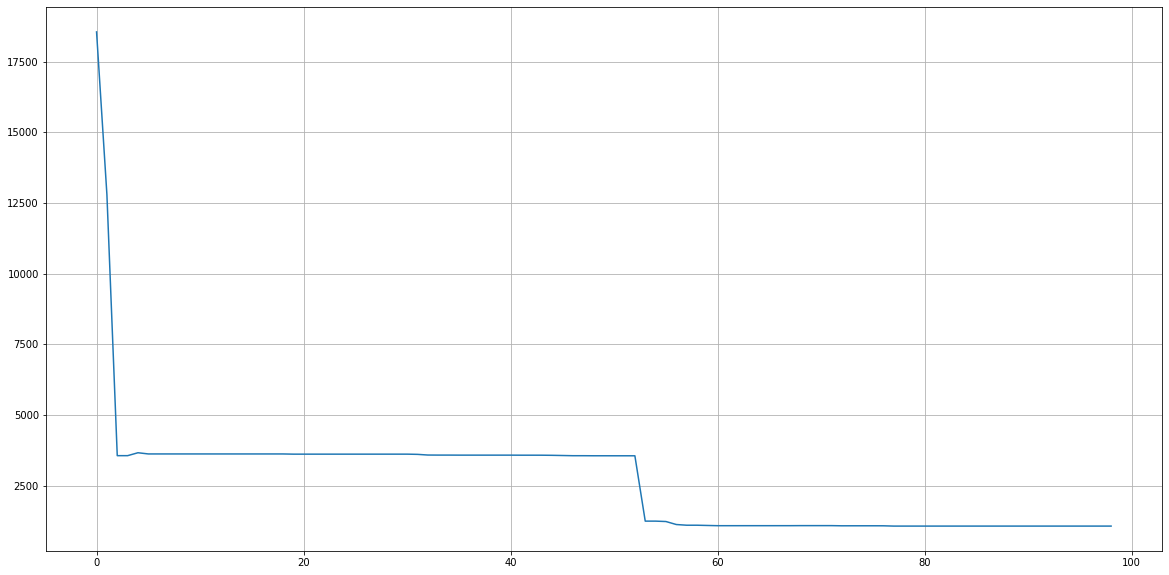

In [8]:
regression(*line, BFGS)

In [359]:
f = lambda size : lambda x,y : (x + 2*y - 7)**2 + (2*x + y - 5)**2

In [360]:
grad = lambda x, y: [2*(x+2*y - 7)+2*2*(2*x + y -5), 2*2*(x+2*y-7) + 2*(2*x + y - 5)]

In [364]:
points = BFGS(f, 0, [5,5], grad, 10)

1
2
3
4
5
6
7


In [369]:
# Обобщенная функция для вычисления градиента.
def grad(f): 
    def grad_help(*args):
        h = 1e-5
        dim = len(args)
        return [(f(*[args[j] + (h if j == i else 0) for j in range(dim)]) -
                f(*[args[j] - (h if j == i else 0) for j in range(dim)]))/(2*h)
                for i in range(dim)]
    return grad_help

# Градиентный спуск
# Число вычислений grad f  = epoch - 1
# Число вычислений f = 0
def gradient_descent(f, lr0, d, epoch, x, counters = [0,0]):
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        x = x - lr0*np.exp(-d*i) * np.array(grad(f)(*x))
        points[i] = x  
    
    counters[1] = epoch -1
    return points

# Градиентный спуск с постоянным шагом.
def gradient_descent_const(f, lr, epoch, x):
    return gradient_descent(f, lr, 0, epoch, x)


In [368]:
points

[[1.5, 1.75],
 [0.11274587989682461, 3.8945867987817144],
 [1.1095824862155017, 2.9652211626249576],
 [0.995946068846666, 2.992213283230686],
 [0.9996011046261949, 3.000574423203834],
 [1.0000167135627767, 2.9999846804043084],
 [0.9999999175633317, 3.000000018004383]]